# Variational Autoencoder

Training a VAE on the mnist dataset

In [48]:
import os
import time
from collections import defaultdict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [26]:
# utility functions
def imshow(img) -> None:
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def count_parameters(model) -> int:
    """
    Returns number of trainable parameters in pt model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [55]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [36]:
# training hyperparameters
batch_size = 128
test_batch_size = 1
lr = 1e-3         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 20
input_dim = 784   # MNIST images are 28x28
latent_dim = 20   # z

In [37]:
# load dataset and dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(torch.flatten)])

trainset = torchvision.datasets.MNIST(root='../.data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../.data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

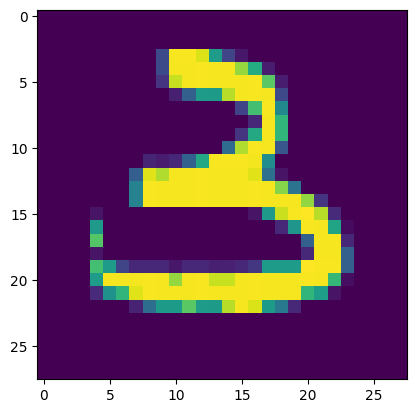

In [38]:
# display data
imshow(next(iter(trainloader))[0][0].view(1, 28, 28))

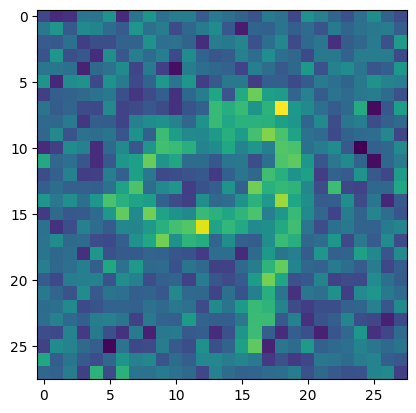

In [61]:
# display data
gaussian = AddGaussianNoise(0., 0.4)
imshow(gaussian(next(iter(trainloader))[0][0]).view(1, 28, 28))

In [39]:
# define autoencoder model
class VAE(nn.Module):
    def __init__(self, input_dim: int=768, latent_dim: int=16):
        super(VAE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            # The output will be split into mean/mu and log variance/logvar
            nn.Linear(32, latent_dim * 2)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent = self.enc(x)
        mu, logvar = torch.chunk(latent, 2, dim=-1)
        z = self.reparameterize(mu, logvar)
        recon_x = self.dec(z)
        return recon_x, mu, logvar

In [40]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

vae_model = VAE(input_dim, latent_dim).to(device)
print("VAE number of params: ", count_parameters(vae_model))

optimizer = torch.optim.SGD(vae_model.parameters(), lr=lr, weight_decay=w_d)
optimizer = optim.Adam(vae_model.parameters(), lr=lr)

VAE number of params:  1155704


## Train VAE for reconstruction of all digits

In [41]:
vae_model.train()
start = time.perf_counter()

for epoch in range(epochs):
    ep_start = time.perf_counter()
    running_loss = 0.0
    for bx, (X, _) in enumerate(trainloader):
        X = X.view(X.size(0), -1).to(device)
        optimizer.zero_grad()  # zero the parameter gradients
        # forward + backward + optimize
        X_recon_batch, mu, logvar = vae_model(X)
        loss = loss_function(X_recon_batch, X, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(trainset)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.perf_counter()

    print("-----------------------------------------------")
    print(f"Epoch {epoch+1}/{epochs}. Loss: {epoch_loss}")
    print(f"Epoch {epoch+1} took {ep_end - ep_start:.2f}s ")
end = time.perf_counter()
print("-----------------------------------------------")
print(f"Training Complete: {end-start:.2f}")

-----------------------------------------------
Epoch 1/20. Loss: 203.39435934244793
Epoch 1 took 4.51s 
-----------------------------------------------
Epoch 2/20. Loss: 181.91958785807293
Epoch 2 took 4.48s 
-----------------------------------------------
Epoch 3/20. Loss: 168.70414213867187
Epoch 3 took 4.56s 
-----------------------------------------------
Epoch 4/20. Loss: 159.20346385091145
Epoch 4 took 4.58s 
-----------------------------------------------
Epoch 5/20. Loss: 152.3139013997396
Epoch 5 took 4.54s 
-----------------------------------------------
Epoch 6/20. Loss: 146.81409303385416
Epoch 6 took 4.64s 
-----------------------------------------------
Epoch 7/20. Loss: 142.36486946614582
Epoch 7 took 4.57s 
-----------------------------------------------
Epoch 8/20. Loss: 139.70426778971355
Epoch 8 took 4.60s 
-----------------------------------------------
Epoch 9/20. Loss: 137.82570540364583
Epoch 9 took 4.50s 
-----------------------------------------------
Epoch 10

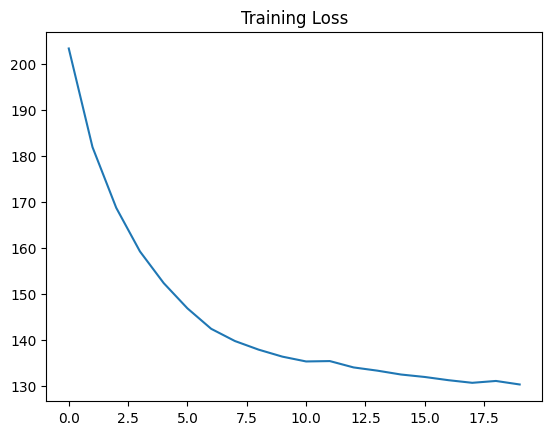

In [42]:
plt.title("Training Loss")
plt.plot(metrics['train_loss'])
plt.show()

## Generate new images with VAE

In [50]:
with torch.no_grad():
    z = torch.randn(batch_size, latent_dim).to(device)
    sample = vae_model.dec(z).to(device)
    os.makedirs('./samples', exist_ok=True)

    save_image(sample.view(batch_size, 1, 28, 28),
               './samples/samples.png')

## Test VAE

In [59]:
gaussian = AddGaussianNoise(0., 0.4)
vae_model.eval()

loss_dist = []
label_ids = []  # 1 is anomaly, 0 is normal

# shuffle should be set to false for testing data
for bx, (X, _) in enumerate(testloader):
    if np.random.rand() < 0.4:
        X = gaussian(X)
        # limit values between 0 and 1
        X = (X - X.min()) / (X.max() - X.min())
        label_ids.append(1)
    else:
        label_ids.append(0)
    X = X.to(device)
    X_reconstructed, mu, logvar = vae_model(X)
    loss = loss_function(X_reconstructed, X, mu, logvar)
    loss_dist.append(loss.item())

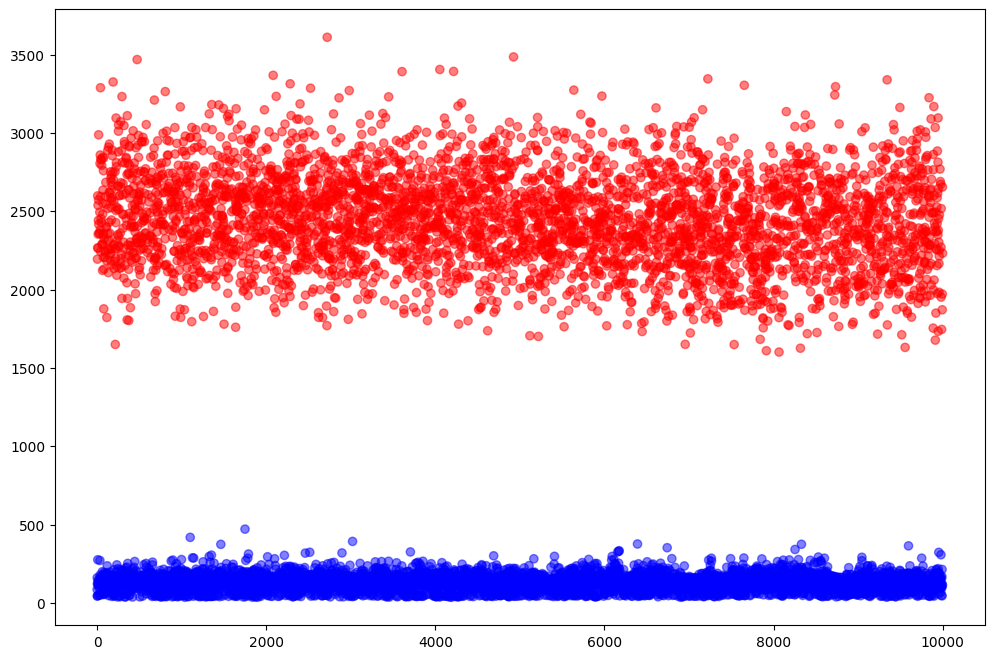

In [60]:
plt.figure(figsize=(12, 8))

color_list = ["blue" if label == 0 else "red" for label in label_ids]

plt.scatter(range(len(loss_dist)), loss_dist, color=color_list, alpha=0.5)
plt.show()

<Figure size 1200x600 with 0 Axes>

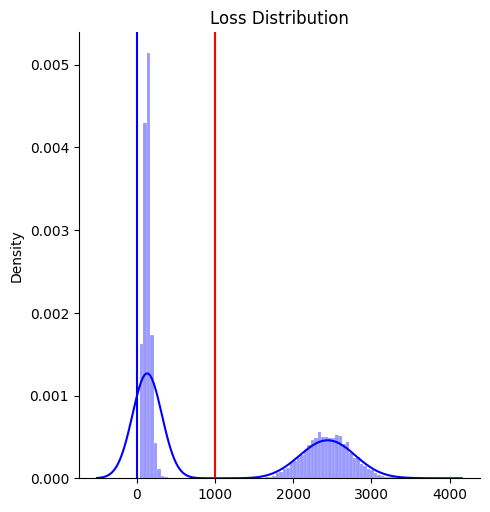

In [64]:
lower_threshold = 0.8
upper_threshold = 1000.0
plt.figure(figsize=(12,6))
sns.displot(loss_dist, bins=80, kde=True, stat="density", 
            color='blue', kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),)
plt.title('Loss Distribution')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')
plt.show()

In [68]:
# evaluate anomaly classifier that uses the reconstruction loss and a threshold from our observations
thres = 1000.0  # threshold is based on the figure above
pred_label_ids = [0 if loss < thres else 1 for loss in loss_dist]

In [69]:
tp, tn, fp, fn = 0, 0, 0, 0

for pred, target in zip(pred_label_ids, label_ids):
    if pred and target:
        tp += 1
    elif pred and not target:
        fp += 1
    elif not pred and target:
        fn += 1
    elif not pred and not target:
        tn += 1

In [70]:
print(f"Accuracy = {100 * (tp + tn) / (tp + tn + fp + fn)}%")
print(f"Precision = {100 * tp / (tp + fp)}%")
print(f"Recall = {100 * tp / (tp + fn)}%")
# high accuracy because adding noise and the standardization causes data to become too different from the original data

Accuracy = 100.0%
Precision = 100.0%
Recall = 100.0%
